# Импорт библиотек

In [183]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Задание начальных условий:
- моменты инерций
- шаг дискретизации времени
- количество временных шагов
- ограничение на управляющий момент
- целевая ориентация
- начальные угловые скорости

In [184]:
I = np.diag([10, 10, 10]) 
I_inv = np.linalg.inv(I)
dt = 0.1 
N = 1200 
torque_bound = 0.1 
target_orientation = np.array([1, 0, 0, 0]) 

q0 = np.array([0.707, 0.707, 0, 0])
w0 = np.array([0.9, 0.5, 0.5])

linear_velocity = np.array([0.01, 0.01, 0.005])

# Задание уравнений движения

In [185]:
def dynamics(q, w, torque):
    q = ca.MX(q)
    w = ca.MX(w)
    torque = ca.MX(torque)
    
    w_dot = I_inv @ (torque - ca.cross(w, I @ w))
    
    dqdt = 0.5 * ca.vertcat(
        -q[1]*w[0] - q[2]*w[1] - q[3]*w[2],
        q[0]*w[0] + q[2]*w[2] - q[3]*w[1],
        q[0]*w[1] - q[1]*w[2] + q[3]*w[0],
        q[0]*w[2] + q[1]*w[1] - q[2]*w[0]
    )
    
    return dqdt, w_dot

# Создание оптимизационного объекта

In [186]:
opti = ca.Opti()

U = opti.variable(3, N)  
X = opti.variable(7, N+1)

opti.subject_to(X[:, 0] == ca.vertcat(q0, w0))

# Определение функции динамики системы

In [187]:
for k in range(N):
    dqdt, w_dot = dynamics(X[0:4, k], X[4:7, k], U[:, k])
    q_next = X[0:4, k] + dt * dqdt
    w_next = X[4:7, k] + dt * w_dot
    opti.subject_to(X[:, k+1] == ca.vertcat(q_next, w_next))

# Оптимизационный функционал


In [188]:
J = 0
for k in range(N):
    J += ca.sumsqr(U[:, k])
    J += ca.sumsqr(X[0:4, k+1] - target_orientation)
J += ca.sumsqr(X[4:7, N])
opti.minimize(J)

# Ограничения


In [189]:
for k in range(N):
    opti.subject_to(-torque_bound <= U[:, k])
    opti.subject_to(U[:, k] <= torque_bound)

# Настройка и решение задачи


In [190]:
opti.solver('ipopt')
sol = opti.solve()

X_sol = sol.value(X)
U_sol = sol.value(U)
q_sol = X_sol[0:4, :]
w_sol = X_sol[4:7, :]

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    63607
Number of nonzeros in inequality constraint Jacobian.:     7200
Number of nonzeros in Lagrangian Hessian.............:    30003

Total number of variables............................:    12007
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     8407
Total number of inequality constraints...............:     7200
        inequality constraints with only lower bounds:     3600
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:     3600

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.00e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

# Функция для преобразования кватерниона в матрицу поворота


In [191]:
def quaternion_to_rotation_matrix(q):
    q = q / np.linalg.norm(q)
    q0, q1, q2, q3 = q
    R = np.array([
        [1 - 2*(q2*q2 + q3*q3), 2*(q1*q2 - q0*q3), 2*(q1*q3 + q0*q2)],
        [2*(q1*q2 + q0*q3), 1 - 2*(q1*q1 + q3*q3), 2*(q2*q3 - q0*q1)],
        [2*(q1*q3 - q0*q2), 2*(q2*q3 + q0*q1), 1 - 2*(q1*q1 + q2*q2)]
    ])
    return R

# Создание 3D фигур

In [192]:
cube_definition = [
    [-0.1, -0.1, -0.1],
    [ 0.1, -0.1, -0.1],
    [ 0.1,  0.1, -0.1],
    [-0.1,  0.1, -0.1],
    [-0.1, -0.1,  0.1],
    [ 0.1, -0.1,  0.1],
    [ 0.1,  0.1,  0.1],
    [-0.1,  0.1,  0.1]
]

small_cube_definition = [
    [-0.05, -0.05, -0.05],
    [ 0.05, -0.05, -0.05],
    [ 0.05,  0.05, -0.05],
    [-0.05,  0.05, -0.05],
    [-0.05, -0.05,  0.05],
    [ 0.05, -0.05,  0.05],
    [ 0.05,  0.05,  0.05],
    [-0.05,  0.05,  0.05]
]

def draw_cube(ax, points, color='b'):
    vertices = [
        [points[j] for j in [0, 1, 5, 4]],
        [points[j] for j in [7, 6, 2, 3]],
        [points[j] for j in [0, 3, 7, 4]],
        [points[j] for j in [1, 2, 6, 5]],
        [points[j] for j in [0, 1, 2, 3]],
        [points[j] for j in [4, 5, 6, 7]]
    ]
    faces = Poly3DCollection(vertices, linewidths=0.2, edgecolors='k', facecolors=color, alpha=0.5)
    ax.add_collection3d(faces)

# Перемещение куба

In [193]:
spacecraft_trajectory = []
small_cube_corner_trajectory = []

for num in range(N):
    position = linear_velocity * num * dt
    rotation_matrix = quaternion_to_rotation_matrix(q_sol[:, num])
    
    spacecraft_trajectory.append(position)
    
    corner_offset = np.array([0.05, 0.05, 0])
    corner_position = np.dot(small_cube_definition[0], rotation_matrix.T) + corner_offset + position
    small_cube_corner_trajectory.append(corner_position)

def set_axes_equal(ax):
    limits = np.array([
        ax.get_xlim(),
        ax.get_ylim(),
        ax.get_zlim()
    ])
    ranges = limits[:, 1] - limits[:, 0]
    centers = np.mean(limits, axis=1)
    max_range = 0.5 * max(ranges)

    ax.set_xlim([centers[0] - max_range, centers[0] + max_range])
    ax.set_ylim([centers[1] - max_range, centers[1] + max_range])
    ax.set_zlim([centers[2] - max_range, centers[2] + max_range])

# Функция анимации движений

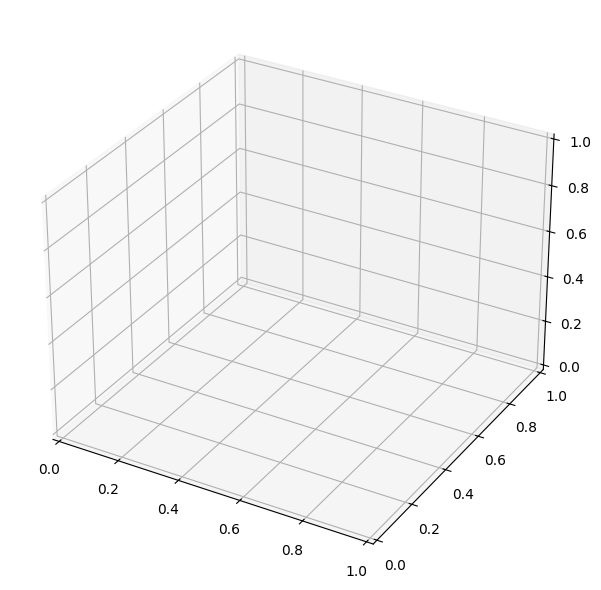

In [194]:
def update(num):
    ax.cla()
    current_position = spacecraft_trajectory[num]

    limit_offset = 0.5  
    ax.set_xlim([current_position[0] - limit_offset, current_position[0] + limit_offset])
    ax.set_ylim([current_position[1] - limit_offset, current_position[1] + limit_offset])
    ax.set_zlim([current_position[2] - limit_offset, current_position[2] + limit_offset])
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Движение в пространстве КА')

    rotation_matrix = quaternion_to_rotation_matrix(q_sol[:, num])
    position = spacecraft_trajectory[num]
    
    
    points_big_cube = [np.dot(cube_definition[j], rotation_matrix.T) + position for j in range(len(cube_definition))]
    draw_cube(ax, points_big_cube, 'b')
    
    
    points_small_cube = [np.dot(small_cube_definition[j], rotation_matrix.T) + corner_offset + position for j in range(len(small_cube_definition))]
    draw_cube(ax, points_small_cube, 'r')

    
    if num > 0:
        trajectory_array = np.array(spacecraft_trajectory)
        ax.plot3D(trajectory_array[:num, 0], trajectory_array[:num, 1], trajectory_array[:num, 2], 'b--')

    
    if num > 0:
        trajectory = np.array(small_cube_corner_trajectory)
        ax.plot3D(trajectory[:num, 0], trajectory[:num, 1], trajectory[:num, 2], 'r--')

    set_axes_equal(ax)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ani = FuncAnimation(fig, update, frames=N, interval=100)

plt.tight_layout()
plt.show()

# Построение графика косинуса между углами двух тел

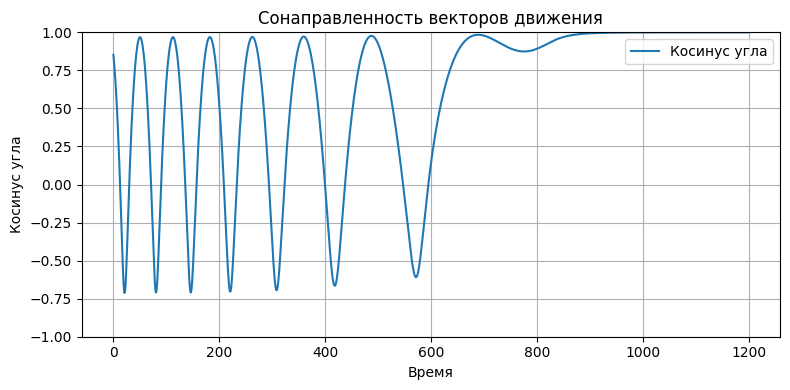

In [195]:
cos_values = np.zeros(N - 1)
for num in range(1, N):
    v1 = spacecraft_trajectory[num] - spacecraft_trajectory[num - 1]
    v2 = small_cube_corner_trajectory[num] - small_cube_corner_trajectory[num - 1]
    
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    
    
    if norm_v1 > 0 and norm_v2 > 0:
        cos_angle = np.dot(v1, v2) / (norm_v1 * norm_v2)
    else:
        cos_angle = np.nan  

            
    cos_values[num - 1] = cos_angle

plt.figure(figsize=(8, 4))
plt.plot(cos_values, label='Косинус угла')
plt.ylim([-1, 1])
plt.xlabel('Время')
plt.ylabel('Косинус угла')
plt.title('Сонаправленность векторов движения')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Сохранение анимации

In [196]:
ani.save('/Users/dmartynenko99/Desktop/orientation_control.mp4', writer='ffmpeg', fps=10)
